In [1]:
import pandas as pd
import numpy as np
from pathlib import Path
import os
import matplotlib as mpl
import matplotlib.pyplot as plt
from linearmodels.panel import PanelOLS

pd.options.display.max_columns = 500
pd.options.display.max_rows = 5000

os.getcwd()
os.chdir('c:\\Users\\zach_\\Desktop\\Research\\Github\\RFE_project')

In [2]:
# load aggregate pattern
datapath = Path("data/cleaned/agg_pattern.h5")
df = pd.read_hdf(datapath, key = "data")

# print sector names
sectors = df['sector_2'].unique()
print(sectors)

[11 21 22 23 31 42 44 48 51 52 53 54 55 56 61 62 71 72 81]


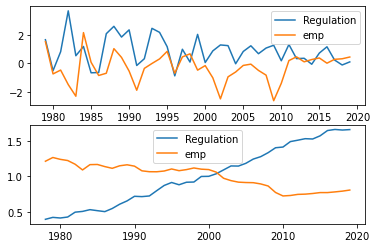

In [3]:
# plot sector regulation and variable correlation
df_sector = df[df.sector_2 == 31]
var = "emp"
x = df_sector.year
y1 = np.log(df_sector.industry_restrictions_2_0) - np.log(df_sector.industry_restrictions_2_0.shift(+1))
y1_normalized = y1/y1.std()
y1_long = (df_sector.industry_restrictions_2_0)
y1_long_normalized = y1_long/y1_long.mean()

y2 = (df_sector[var] - df_sector[var].shift(1))
y2_normalized = y2/y2.std()
y2_long = (df_sector[var])
y2_long_normalized = y2_long/y2_long.mean()

fig, (ax1, ax2) = plt.subplots(2,1)
ax1.plot(x, y1_normalized, label='Regulation')
ax1.plot(x, y2_normalized, label=var)
ax1.legend()

ax2.plot(x, y1_long_normalized, label='Regulation')
ax2.plot(x, y2_long_normalized, label=var)
ax2.legend()

In [16]:
# load life path data
datapath = Path("data/cleaned/life_path_sec_ag.h5")
df = pd.read_hdf(datapath, key="data")

In [17]:
# check lags
print(df.columns.tolist()[0:10])
df_test = df[(df.age_coarse == "05") & (df.sector == 1100 )]
df_test[["year", "L_1_log_restriction_2_0", "L_2_log_restriction_2_0"]].head()

['year', 'sector', 'age_coarse', 'firms', 'estabs', 'emp', 'denom', 'estabs_entry', 'estabs_exit', 'job_creation']


,year,L_1_log_restriction_2_0,L_2_log_restriction_2_0
5,1978,10.344255,10.322565
2253,1979,10.335748,10.344255
4501,1980,10.377319,10.335748
6749,1981,10.467677,10.377319
8997,1982,10.481909,10.467677


In [18]:
# ols estimation
depend_var = "log_emp"
temp_dict = []
for age in df.age_coarse.unique()[1:]:
    
    # load data
    data = df[df.age_coarse == age]

    # sample restriction
    data = data[data.year > 1985]

    # regression
    data = data.set_index(['sector', 'year'])

    # regression
    data1 = data.loc[:, ["L_0_log_restriction_2_0", "L_1_log_restriction_2_0", "L_0_chg_log_restriction_2_0",
                        "L_0_entry_rate_whole", "L_1_entry_rate_whole", 
                        "L_0_log_gdp", "L_1_log_gdp",
                        "death_rate", "emp",
                        'sector_2', depend_var, 'firms']].dropna()
    mod1 = PanelOLS.from_formula(formula = f'{depend_var} ~ \
                                            + L_0_entry_rate_whole    \
                                            + L_0_log_gdp    \
                                            + L_0_log_restriction_2_0 + EntityEffects + TimeEffects',
                                            weights=data1['firms'], data = data1, drop_absorbed=True)

    res = mod1.fit(cov_type='heteroskedastic')

    # results
    vnames = ["L_0_log_restriction_2_0"]
    for v_name in vnames:
        dict1 = {}
        coefs_value = res.params[v_name]
        std = res.std_errors[v_name]
        lower_ci = res.conf_int().loc[v_name, "lower"]
        upper_ci = res.conf_int().loc[v_name, "upper"]
        p_value = res.pvalues[v_name]
        nobs = res.nobs
        sign = (lower_ci * upper_ci > 0)
        dict1.update({"name": v_name, "age": age, "Coef": coefs_value,
                      "std":std,
                        "lower_ci": lower_ci, "upper_ci": upper_ci,
                        "p values":p_value, "significance": sign,
                        "# obs":nobs}) 
        temp_dict.append(dict1)
        
df_coefs_age = pd.DataFrame(temp_dict)
df_coefs_age = df_coefs_age.sort_values(by=['name', 'age'])
df_coefs_age

,name,age,Coef,std,lower_ci,upper_ci,p values,significance,# obs
0,L_0_log_restriction_2_0,01,-0.072901,0.048118,-0.167225,0.021423,0.129800,False,8129
1,L_0_log_restriction_2_0,02,-0.033117,0.048797,-0.128773,0.062538,0.497367,False,8102
2,L_0_log_restriction_2_0,03,-0.034566,0.048807,-0.130240,0.061108,0.478828,False,8097
3,L_0_log_restriction_2_0,04,-0.017578,0.049784,-0.115168,0.080013,0.724043,False,8082
4,L_0_log_restriction_2_0,05,-0.034109,0.048266,-0.128722,0.060505,0.479785,False,8061
5,L_0_log_restriction_2_0,06-10,0.012161,0.045163,-0.076371,0.100693,0.787733,False,8188
6,L_0_log_restriction_2_0,11+,0.050449,0.030738,-0.009806,0.110704,0.100787,False,8262


In [19]:
# IV with lags
from linearmodels.iv import IV2SLS

depend_var = "log_emp"
temp_dict = []
for age in df.age_coarse.unique()[1:]:
    
    # load data
    data = df[df.age_coarse == age]

    # sample restriction
    data = data[(data.year > 1985) & (data.year < 2020)]

    # regression
    data1 = data.loc[:, ["L_0_log_restriction_2_0", "L_0_bartik_iv", 
                         "L_1_log_restriction_2_0", "L_1_bartik_iv", 
                         "L_0_chg_log_restriction_2_0", "L_0_chg_bartik_iv", 
                        "L_0_chg_entry_rate_whole", "L_0_entry_rate_whole", "L_1_entry_rate_whole",
                        "L_0_chg_log_gdp", "L_0_log_gdp", "L_1_log_gdp", "emp", "year", "sector",
                        'sector_2', depend_var, 'firms']].dropna()
    
    formula_txt = f'{depend_var} ~  C(year) + C(sector) \
      + L_0_entry_rate_whole  \
      + L_0_log_gdp     \
      + [L_0_chg_log_restriction_2_0 + L_1_log_restriction_2_0 \
        ~ L_0_chg_bartik_iv + L_1_bartik_iv]'
        
    mod1 = IV2SLS.from_formula(
      formula = formula_txt, weights=data1['firms'], data = data1
    )

    res = mod1.fit(cov_type='heteroskedastic')

    # results
    vnames = ["L_0_chg_log_restriction_2_0", "L_1_log_restriction_2_0"]
    for v_name in vnames:
        dict1 = {}
        coefs_value = res.params[v_name]
        std = res.std_errors[v_name]
        lower_ci = res.conf_int().loc[v_name, "lower"]
        upper_ci = res.conf_int().loc[v_name, "upper"]
        p_value = res.pvalues[v_name]
        nobs = res.nobs
        sign = (lower_ci * upper_ci > 0)
        dict1.update({"name": v_name, "age": age, "Coef": coefs_value,
                      "std":std,
                        "lower_ci": lower_ci, "upper_ci": upper_ci,
                        "p values":p_value, "significance": sign,
                        "# obs":nobs}) 
        temp_dict.append(dict1)
        
df_coefs_age = pd.DataFrame(temp_dict)
df_coefs_age = df_coefs_age.sort_values(by=['name', 'age'])
df_coefs_age

,name,age,Coef,std,lower_ci,upper_ci,p values,significance,# obs
0,L_0_chg_log_restriction_2_0,01,0.861783,0.899068,-0.900357,2.623924,3.377956e-01,False,8129
2,L_0_chg_log_restriction_2_0,02,2.212430,0.993853,0.264515,4.160345,2.600649e-02,True,8102
4,L_0_chg_log_restriction_2_0,03,2.395402,0.958143,0.517477,4.273328,1.241768e-02,True,8097
6,L_0_chg_log_restriction_2_0,04,1.418819,0.914414,-0.373399,3.211037,1.207541e-01,False,8082
8,L_0_chg_log_restriction_2_0,05,0.824841,0.824429,-0.791010,2.440691,3.170687e-01,False,8061
10,L_0_chg_log_restriction_2_0,06-10,0.156726,0.690970,-1.197550,1.511002,8.205635e-01,False,8188
12,L_0_chg_log_restriction_2_0,11+,-0.168286,0.537594,-1.221952,0.885379,7.542536e-01,False,8262
1,L_1_log_restriction_2_0,01,0.934743,0.149207,0.642304,1.227183,3.734151e-10,True,8129
3,L_1_log_restriction_2_0,02,0.937526,0.157535,0.628762,1.246290,2.661711e-09,True,8102
5,L_1_log_restriction_2_0,03,0.905420,0.164900,0.582222,1.228619,4.003123e-08,True,8097


In [28]:
# IV
from linearmodels.iv import IV2SLS

depend_var = "estabs_entry_rate"
temp_dict = []
for age in df.age_coarse.unique()[1:]:
    
    # load data
    data = df[df.age_coarse == age]

    # sample restriction
    data = data[(data.year > 1985) & (data.year < 2020)]

    # regression
    data1 = data.loc[:, ["L_0_log_restriction_2_0", "L_0_bartik_iv", 
                         "L_1_log_restriction_2_0", "L_1_bartik_iv", 
                         "L_0_chg_log_restriction_2_0", "L_0_chg_bartik_iv", 
                        "L_0_chg_entry_rate_whole", "L_0_entry_rate_whole", "L_1_entry_rate_whole",
                        "L_0_chg_log_gdp", "L_0_log_gdp", "L_1_log_gdp", "emp", "year", "sector",
                        'sector_2', depend_var, 'firms']].dropna()
    
    formula_txt = f'{depend_var} ~  C(year) + C(sector) \
      + L_0_log_gdp + L_1_log_gdp    \
      + [L_0_log_restriction_2_0 ~ L_0_bartik_iv ]'
        
    mod1 = IV2SLS.from_formula(
      formula = formula_txt, weights=data1['firms'], data = data1
    )

    res = mod1.fit(cov_type='heteroskedastic')

    # results
    vnames = ["L_0_log_restriction_2_0"]
    for v_name in vnames:
        dict1 = {}
        coefs_value = res.params[v_name]
        std = res.std_errors[v_name]
        lower_ci = res.conf_int().loc[v_name, "lower"]
        upper_ci = res.conf_int().loc[v_name, "upper"]
        p_value = res.pvalues[v_name]
        nobs = res.nobs
        sign = (lower_ci * upper_ci > 0)
        dict1.update({"name": v_name, "age": age, "Coef": coefs_value,
                      "std":std,
                        "lower_ci": lower_ci, "upper_ci": upper_ci,
                        "p values":p_value, "significance": sign,
                        "# obs":nobs}) 
        temp_dict.append(dict1)
        
df_coefs_age = pd.DataFrame(temp_dict)
df_coefs_age = df_coefs_age.sort_values(by=['name', 'age'])
df_coefs_age

,name,age,Coef,std,lower_ci,upper_ci,p values,significance,# obs
0,L_0_log_restriction_2_0,01,0.028591,0.007695,0.013510,0.043672,2.026109e-04,True,8129
1,L_0_log_restriction_2_0,02,0.026014,0.007219,0.011866,0.040162,3.136440e-04,True,8102
2,L_0_log_restriction_2_0,03,0.034435,0.006958,0.020798,0.048073,7.455947e-07,True,8097
3,L_0_log_restriction_2_0,04,0.034010,0.007757,0.018807,0.049214,1.163034e-05,True,8082
4,L_0_log_restriction_2_0,05,0.025962,0.007399,0.011460,0.040463,4.499693e-04,True,8061
5,L_0_log_restriction_2_0,06-10,0.024511,0.005562,0.013611,0.035412,1.047095e-05,True,8188
6,L_0_log_restriction_2_0,11+,0.036412,0.007472,0.021767,0.051056,1.098576e-06,True,8262


In [21]:
# FIRST STAGE
from linearmodels.iv import IV2SLS

depend_var = "estabs_entry_rate"
temp_dict = []
for age in df.age_coarse.unique()[1:]:
    
    # load data
    data = df[df.age_coarse == age]

    # sample restriction
    data = data[(data.year > 1985) & (data.year < 2020)]

    # regression
    data1 = data.loc[:, ["L_0_log_restriction_2_0", "L_0_bartik_iv", 
                         "L_1_log_restriction_2_0", "L_1_bartik_iv", 
                         "L_0_chg_log_restriction_2_0", "L_0_chg_bartik_iv", 
                        "L_0_chg_entry_rate_whole", "L_0_entry_rate_whole", "L_1_entry_rate_whole",
                        "L_0_chg_log_gdp", "L_0_log_gdp", "L_1_log_gdp", "emp", "year", "sector",
                        'sector_2', depend_var, 'firms']].dropna()
    
    formula_txt = f'L_0_log_restriction_2_0 ~  C(year) + C(sector) \
      + L_0_entry_rate_whole + L_1_entry_rate_whole \
      + L_0_log_gdp + L_1_log_gdp    \
      + [L_0_bartik_iv ~ L_0_bartik_iv ]'
        
    mod1 = IV2SLS.from_formula(
      formula = formula_txt, weights=data1['firms'], data = data1
    )

    res = mod1.fit(cov_type='heteroskedastic')

    # results
    vnames = ["L_0_bartik_iv"]
    for v_name in vnames:
        dict1 = {}
        coefs_value = res.params[v_name]
        std = res.std_errors[v_name]
        lower_ci = res.conf_int().loc[v_name, "lower"]
        upper_ci = res.conf_int().loc[v_name, "upper"]
        p_value = res.pvalues[v_name]
        nobs = res.nobs
        sign = (lower_ci * upper_ci > 0)
        dict1.update({"name": v_name, "age": age, "Coef": coefs_value,
                      "std":std,
                        "lower_ci": lower_ci, "upper_ci": upper_ci,
                        "p values":p_value, "significance": sign,
                        "# obs":nobs}) 
        temp_dict.append(dict1)
        
df_coefs_age = pd.DataFrame(temp_dict)
df_coefs_age = df_coefs_age.sort_values(by=['name', 'age'])
df_coefs_age

,name,age,Coef,std,lower_ci,upper_ci,p values,significance,# obs
0,L_0_bartik_iv,01,0.121170,0.007619,0.106236,0.136103,0.0,True,8129
1,L_0_bartik_iv,02,0.122543,0.007717,0.107419,0.137668,0.0,True,8102
2,L_0_bartik_iv,03,0.123696,0.007901,0.108211,0.139181,0.0,True,8097
3,L_0_bartik_iv,04,0.122411,0.008257,0.106227,0.138595,0.0,True,8082
4,L_0_bartik_iv,05,0.122389,0.008310,0.106102,0.138675,0.0,True,8061
5,L_0_bartik_iv,06-10,0.124796,0.008585,0.107970,0.141621,0.0,True,8188
6,L_0_bartik_iv,11+,0.127929,0.008819,0.110645,0.145213,0.0,True,8262


In [48]:
# pooled data
# load data
depend_var = "log_avg_emp"
data = df[df.age_coarse != "00"]

# sample restriction
data = data[(data.year > 1985) & (data.year < 2020)]

# regression
data1 = data.loc[:, ["L_0_log_restriction_2_0", "L_1_log_restriction_2_0", "L_0_log_restriction_2_0_init",
                        "L_0_entry_rate_whole", "L_1_entry_rate_whole", "L_2_entry_rate_whole", "L_3_entry_rate_whole",
                        "L_0_log_gdp", "L_1_log_gdp", "L_2_log_gdp", "L_3_log_gdp",
                        "death_rate", "age_coarse", "emp", "year", "sector",
                        'sector_2', depend_var, 'firms']].dropna()
mod1 = IV2SLS.from_formula(formula = f'{depend_var} ~ C(age_coarse) + C(year) + C(sector) \
                                        + L_0_entry_rate_whole  \
                                        + L_0_log_gdp  \
                                        + [L_0_log_restriction_2_0:C(age_coarse) ~ L_0_log_restriction_2_0_init:C(age_coarse) ]',
                                        weights=data1['firms'], data = data1)

res = mod1.fit(cov_type='heteroskedastic')
res.summary;

In [3]:
# create shift share

In [4]:
def lag_variable(df, time_var, id_var, var, lags):
    """
    lag_variable create lag variables by groups   
    Args:
        df [DataFrame]: dataframe
        time_var [lst]: time variable
        id_var [list of string]: id variable
        var [lst]: lagged varible
        lags: number of lags (1 means one lag)
    """

    index_var = time_var + id_var

    df = df.set_index(index_var)
    df_shift = df[var]
    
    shifted = df_shift.groupby(level=id_var).shift(lags)
    shifted = shifted.rename(columns={var[0]: f"L_{lags}_{var[0]}"})
    df = df.join(shifted)
    df = df.reset_index()
    
    return df

In [5]:
# load regulation data
df_doc = pd.read_csv("C:\\Users\\zach_\\Nobackupfile\\Data\\BDS\\Regdata\\regdata_4_0_documents.csv")
df_ind = pd.read_csv("C:\\Users\\zach_\\Nobackupfile\\Data\\BDS\\Regdata\\regdata_4_0_documents_2digit_naics.csv")

# clean variables
baseline_year = 1986
df_doc["year"] = pd.to_numeric(df_doc.year.str.slice(0,4))
df_ind["year"] = pd.to_numeric(df_ind.year.str.slice(0,4))

# create lag variable
df_doc = lag_variable(df_doc, ["year"], ["document_reference"], ["restrictions_2_0"], 1)

# create current measure
doc_var = ["year", "document_reference", "restrictions_1_0","restrictions_2_0", "L_1_restrictions_2_0"]
df_merge = df_ind.merge(df_doc[doc_var], how='left', on=["year", "document_reference"], validate="many_to_one")

df_init = df_merge.loc[df_merge.year == baseline_year, ["NAICS", "probability", "document_reference", "restrictions_2_0"]]
df_init = df_init.rename(columns = {"probability": "probability_init"})

In [6]:
df_init.tail()

,NAICS,probability_init,document_reference,restrictions_2_0
631048,54,0.9997,"Title 9, Part 97",12.0
631049,71,0.0310,"Title 9, Part 97",12.0
631050,44,0.0033,"Title 9, Part 98",26.0
631051,54,1.0000,"Title 9, Part 98",26.0
631052,62,0.0021,"Title 9, Part 98",26.0


In [7]:
df_init["reg_s_d_init"] = df_init["probability_init"] * df_init["restrictions_2_0"]
df_init["reg_s_init"] = df_init.groupby(["NAICS"])["reg_s_d_init"].transform(lambda x: x.sum())
df_init["share_init"] = np.where(df_init["reg_s_d_init"]>0, df_init["reg_s_d_init"] / df_init["reg_s_init"], 0) 
init_var = ["NAICS", "document_reference", "reg_s_d_init", "reg_s_init", "share_init"]
df_merge = df_merge.merge(df_init[init_var], how='left', on=["NAICS", "document_reference"], validate="many_to_one")

In [8]:
for var in ["reg_s_d_init", "reg_s_init", "share_init"]:
    df_merge[var] = np.where(df_merge[var].isna(), 0, df_merge[var])

df_merge[df_merge.year > 1988].head()

,year,document_reference,industry_description,NAICS,probability,restrictions_1_0,restrictions_2_0,L_1_restrictions_2_0,reg_s_d_init,reg_s_init,share_init
727392,1989,"Title 1, Part 10",Retail Trade,44,0.0023,4.0,8.0,8.0,0.0078,26240.771135,2.972474e-07
727393,1989,"Title 1, Part 10",Transportation and Warehousing,48,0.0040,4.0,8.0,8.0,0.0738,93757.179477,7.871397e-07
727394,1989,"Title 1, Part 10",Information,51,0.0063,4.0,8.0,8.0,0.0348,38345.618443,9.075352e-07
727395,1989,"Title 1, Part 10",Public Administration,92,0.0040,4.0,8.0,8.0,0.0180,26481.037613,6.797317e-07
727396,1989,"Title 1, Part 11",Agriculture Forestry Fishing and Hunting,11,0.0012,0.0,0.0,7.0,0.0000,0.000000,0.000000e+00


In [9]:
df_merge["reg_s_d"] = df_merge["probability"] * df_merge["restrictions_2_0"]
df_merge["reg_s"] = df_merge.groupby(["NAICS", "year"])["reg_s_d"].transform(lambda x: x.sum())
df_merge["share"] = np.where(df_merge["reg_s_d"] > 0, df_merge["reg_s_d"] / df_merge["reg_s"], 0) 
df_merge["log_reg_s_d"] = np.where(df_merge["reg_s_d"] > 0, np.log(df_merge["reg_s_d"]), 0)
df_merge["log_reg_d"] = np.where(df_merge["restrictions_2_0"] > 0, np.log(df_merge["restrictions_2_0"]), np.nan) 

c:\Users\zach_\.virtualenvs\RFE_project-5yjSZlxr\lib\site-packages\pandas\core\arraylike.py:397: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
c:\Users\zach_\.virtualenvs\RFE_project-5yjSZlxr\lib\site-packages\pandas\core\arraylike.py:397: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [11]:
df_merge["bartik_iv"] = df_merge["log_reg_d"] * df_merge["share_init"]
df_merge["industry_restrictions_2_0"] = df_merge["reg_s_d"]

In [12]:
regdata = df_merge.groupby(by=["year", "NAICS"])[["industry_restrictions_2_0", "bartik_iv"]].sum()

In [13]:
regdata["log_restrictions_2_0"] = np.log(regdata["industry_restrictions_2_0"])

In [14]:
regdata = regdata.reset_index()

In [15]:
regdata[regdata.year > 1985].corr()

,year,NAICS,industry_restrictions_2_0,bartik_iv,log_restrictions_2_0
year,1.000000e+00,-1.784297e-15,0.261905,-0.503649,0.245143
NAICS,-1.784297e-15,1.000000e+00,-0.150709,-0.214505,-0.052650
industry_restrictions_2_0,2.619046e-01,-1.507094e-01,1.000000,0.202504,0.861408
bartik_iv,-5.036486e-01,-2.145053e-01,0.202504,1.000000,0.177918
log_restrictions_2_0,2.451432e-01,-5.264981e-02,0.861408,0.177918,1.000000


In [ ]:

ind_init_var = ["document_reference", "NAICS", "probability_init"]
df_merge = df_merge.merge(df_ind_init[ind_init_var], how='left', on=["document_reference", "NAICS"], validate="many_to_one")

df_merge["industry_restrictions_2_0"] = df_merge["restrictions_2_0"]*df_merge["probability"]

df_merge["industry_restrictions_2_0_init"] = df_merge["restrictions_2_0"]*df_merge["probability_init"]
df_merge["industry_restrictions_1_0"] = df_merge["restrictions_1_0"]*df_merge["probability"]
df_merge["industry_restrictions_1_0_init"] = df_merge["restrictions_1_0"]*df_merge["probability_init"]
df_merge["industry_restrictions_2_0_chg"] = (df_merge["restrictions_2_0"] - df_merge["L_1_restrictions_2_0"]) * df_merge["probability"]
df_merge["industry_restrictions_2_0_log_chg"] = (np.log(df_merge["restrictions_2_0"]) - np.log(df_merge["L_1_restrictions_2_0"]))*df_merge["probability"]
df_merge["industry_restrictions_2_0_chg_init"] = (df_merge["industry_restrictions_2_0"] - df_merge["L_1_restrictions_2_0"])*df_merge["probability_init"]
df_merge["industry_restrictions_2_0_log_chg_init"] = (np.log(df_merge["restrictions_2_0"]) - np.log(df_merge["L_1_restrictions_2_0"]))*df_merge["probability_init"]

regdata = df_merge.groupby(by=["year", "NAICS"])[["industry_restrictions_2_0", "industry_restrictions_2_0_init",
                                                    "industry_restrictions_2_0_chg", "industry_restrictions_2_0_chg_init",
                                                    "industry_restrictions_2_0_log_chg", "industry_restrictions_2_0_log_chg_init",
                                                    "industry_restrictions_1_0", "industry_restrictions_1_0_init"]].sum()
regdata = regdata.reset_index()
regdata = regdata.rename(columns={"NAICS":"sector_reg"})

In [74]:
regdata.tail()

,year,sector_reg,industry_restrictions_2_0,industry_restrictions_2_0_init,industry_restrictions_2_0_chg,industry_restrictions_2_0_chg_init,industry_restrictions_2_0_log_chg,industry_restrictions_2_0_log_chg_init,industry_restrictions_1_0,industry_restrictions_1_0_init
760,2020,56,107867.302758,9049.477306,168.497903,-4329.503479,NaN,NaN,87652.348682,7303.644605
761,2020,61,55513.459184,15308.727287,-714.244803,-4970.627296,NaN,-2.535927,43429.542971,11283.113041
762,2020,62,45732.585166,5024.633055,589.208302,-1614.109635,NaN,NaN,34586.028448,3957.571966
763,2020,71,27123.132657,4498.939822,-51.714301,-3992.251101,NaN,-0.016242,21568.927742,3784.743419
764,2020,92,29069.286975,7284.200702,-138.966097,-5530.418561,NaN,NaN,23710.398266,5937.792602


In [71]:
df_ind.sort_values(["year", "NAICS"])
df_merge = df_ind.merge(df_doc[["year", "document_reference", "restrictions_2_0"]], how='left', on=["year", "document_reference"], validate="many_to_one")
df_merge["year_init"] = df_merge["year"] - 15
df_merge = df_merge.merge(df_ind_init[["year_init", "document_reference", "NAICS", "probability_init"]], how='left', on=["year_init", "document_reference", "NAICS"], validate="many_to_one")

In [72]:
df_merge["weight_index"] = df_merge["restrictions_2_0"]*df_merge["probability"]
df_merge["weight_index_init"] = df_merge["restrictions_2_0"]*df_merge["probability_init"]

In [77]:
df_merge.tail()

,year,document_reference,industry_description,NAICS,probability,restrictions_2_0,year_init,probability_init,weight_index,weight_index_init
2404407,2020,"Title 9, Part 99",Transportation and Warehousing,48,0.1006,2.0,2005,0.0581,0.2012,0.1162
2404408,2020,"Title 9, Part 99",Information,51,0.0019,2.0,2005,0.0028,0.0038,0.0056
2404409,2020,"Title 9, Part 99",Finance and Insurance,52,0.0014,2.0,2005,0.0039,0.0028,0.0078
2404410,2020,"Title 9, Part 99",Professional Scientific and Technical Services,54,0.0208,2.0,2005,0.0265,0.0416,0.0530
2404411,2020,"Title 9, Part 99",Public Administration,92,0.0716,2.0,2005,0.0290,0.1432,0.0580


In [73]:
df = df_merge.groupby(by=["year", "NAICS"])[["weight_index", "weight_index_init"]].sum()
df = df.reset_index()

In [68]:
df_merge[(df_merge._merge == "left_only") & (df_merge.industry_description == "Wholesale Trade")].head()

AttributeError: 'DataFrame' object has no attribute '_merge'

In [ ]:
df.head()